In [0]:
%matplotlib inline

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [0]:
import torchvision

In [0]:

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(trainset[0][0].size())
print(len(trainset))
print(len(testset))
print(trainset.classes)

torch.Size([3, 32, 32])
50000
10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [0]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

val_data, train_data = torch.utils.data.random_split(trainset, [1000, 49000])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                          shuffle=True, num_workers=2)

valloader =  torch.utils.data.DataLoader(val_data, batch_size=64,
                                          shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


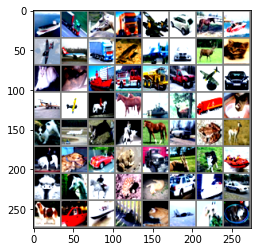

In [8]:

from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

def show(img):
  img = img / 2 + 0.5   
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images)
show(img_grid)

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))
      x = self.pool(F.relu(self.bn2(self.conv2(x))))
      x = self.pool(F.relu(self.bn3(self.conv3(x))))
      #print(x.shape)
      x = x.view(-1, 64 * 6 * 6)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x



In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [0]:
def get_accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [0]:
def validate(net, valoader, criterion):
    val_loss = 0
    val_accuracy = 0
    net.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            accuracy = get_accuracy(outputs, targets)
            val_accuracy += accuracy[0].item()
        avg_loss = val_loss/(batch_idx+1)
        avg_acc = val_accuracy/(batch_idx+1)
        
    return avg_loss, avg_acc

In [0]:
def train_one_epoch(model, trainloader, optimizer, criterion):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = get_accuracy(outputs, targets)
        train_accuracy += accuracy[0].item()
    avg_train_loss = train_loss/(batch_idx+1)
    avg_train_acc = train_accuracy/(batch_idx+1)
    return avg_train_loss, avg_train_acc, model 

In [0]:
import torch.optim as optim
model = Net().to(device)
model.apply(weight_reset)
optimizer = optim.Adam(model.parameters(), lr =0.001)

acc_train = []
loss_train = []
acc_val = []
loss_val = []
for epoch in range(10):
    train_loss, train_acc, model = train_one_epoch(model, trainloader,
                                                 optimizer, criterion)
    val_loss, val_acc = validate(model, valloader, criterion)
    acc_train.append(train_acc)
    loss_train.append(train_loss)
    acc_val.append(val_acc)
    loss_val.append(val_loss)

In [0]:
import matplotlib.pyplot as plt

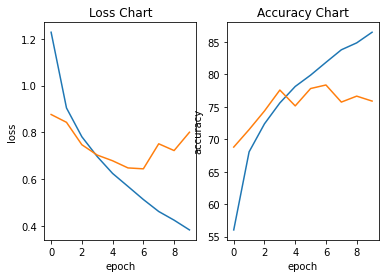

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('Loss Chart')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.plot(loss_train, label='Train loss')
ax1.plot(loss_val)

ax2.set_title('Accuracy Chart')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.plot(acc_train)
ax2.plot(acc_val)

plt.show()